In [49]:
import pandas as pd
from model.getdata import smiles2graph 
from model.CL_model_vas_info import GNNModelWithNewLoss
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

In [50]:
df = pd.read_csv('data/freesolv.csv')
df.head()

,smiles,freesolv
0,CN(C)C(=O)c1ccc(cc1)OC,-11.01
1,CS(=O)(=O)Cl,-4.87
2,CC(C)C=C,1.83
3,CCc1cnccn1,-5.45
4,CCCCCCCO,-4.21


In [51]:
smiles_list = df["smiles"].tolist()
y = df['freesolv'].tolist()
data_list = smiles2graph(
    smiles_list,
    y = y
)
data_list[0]

Data(x=[13, 133], edge_index=[2, 26], edge_attr=[26, 14], global_features=[1, 8], smiles='CN(C)C(=O)c1ccc(cc1)OC', y=[1, 1])

In [ ]:
def load_model_embeddings(data_list, model_dir):
    model_embeddings = []
    for i in range(3):
        model_path = os.path.join(model_dir, str(i), "best_model.pth")

        # Instantiate model with shape matching input data
        model = GNNModelWithNewLoss(
            num_node_features=data_list[0].x.shape[1],
            num_edge_features=data_list[0].edge_attr.shape[1],
            num_global_features=0, # data_list[0].global_features.shape[1],
            hidden_dim=512,
            conv_num = 6
        )

        state_dict = torch.load(model_path, map_location=torch.device("cpu"))
        model.load_state_dict(state_dict['encoder_state_dict'])
        model.eval()

        embeddings = []
        with torch.no_grad():
            for data in data_list:
                emb = model.forward(data.to(torch.device("cpu")))  
                embeddings.append(emb)
        model_embeddings.append(torch.stack(embeddings))
    return model_embeddings

In [53]:
def prepare_dataset(smiles2graph_fn, csv_file, model_dir):
    df = pd.read_csv(csv_file)
    smiles_list = df["smiles"].tolist()
    y = torch.tensor(df["esol"].values, dtype=torch.float32)
    data_list = smiles2graph_fn(smiles_list, y=y)
    embeddings = load_model_embeddings(data_list, model_dir)
    global_features = torch.stack([data.global_features for data in data_list])
    return embeddings, y, global_features

In [56]:
embeddings, y_tensor, global_features = prepare_dataset(smiles2graph, "data/esol.csv", "premodels_new_og/6")


c:\Users\chenxinyi\Documents\GitHub\clean_multi_cl\model\getdata.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  graph.y = torch.tensor(label, dtype=torch.float32).view(1, -1)
C:\Users\chenxinyi\AppData\Local\Temp\ipykernel_4276\86552549.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly 

RuntimeError: Error(s) in loading state_dict for GNNModelWithNewLoss:
	Unexpected key(s) in state_dict: "convs.3.att_src", "convs.3.att_dst", "convs.3.att_edge", "convs.3.bias", "convs.3.lin.weight", "convs.3.lin_edge.weight", "convs.4.att_src", "convs.4.att_dst", "convs.4.att_edge", "convs.4.bias", "convs.4.lin.weight", "convs.4.lin_edge.weight", "convs.5.att_src", "convs.5.att_dst", "convs.5.att_edge", "convs.5.bias", "convs.5.lin.weight", "convs.5.lin_edge.weight", "norms.3.weight", "norms.3.bias", "norms.4.weight", "norms.4.bias", "norms.5.weight", "norms.5.bias". 

In [ ]:
embeddings = torch.stack(embeddings, dim=0)
embeddings = embeddings.squeeze(2)
embeddings = embeddings.permute(1, 0, 2)
embeddings.shape

torch.Size([1128, 3, 512])

In [ ]:
y_tensor.shape

torch.Size([1128])

In [ ]:
N = embeddings.size(0)
train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size
generator  = torch.Generator().manual_seed(42)
full_ds = torch.utils.data.TensorDataset(embeddings, y_tensor, global_features)
train_ds, val_ds, test_ds = random_split(full_ds, [train_size, val_size, test_size], generator=generator)

In [ ]:
class MolDataset(Dataset):
    def __init__(self, embeddings, targets):
        self.X = torch.from_numpy(embeddings).float()
        self.y = torch.from_numpy(targets).float()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(
    train_ds, batch_size=32, shuffle=True,
    num_workers=4, pin_memory=True
)
val_loader = DataLoader(
    val_ds, batch_size=32,
    num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_ds, batch_size=32,
    num_workers=2, pin_memory=True
)

In [ ]:
for data in train_loader:
    x,y,g = data
    print(x.shape, y.shape, g.shape)
    break

torch.Size([32, 3, 512]) torch.Size([32]) torch.Size([32, 1, 8])


In [ ]:
class TransformerFusionModel(nn.Module):
    def __init__(self, emb_dim, hidden_dim=64):
        super().__init__()
        self.k_proj = nn.Linear(emb_dim, emb_dim)
        self.v_proj = nn.Linear(emb_dim, emb_dim)
        self.query  = nn.Parameter(torch.randn(emb_dim))
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim+32, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )
        self.global_encoder = nn.Linear(8, 32)

    def forward(self, x, global_features):
        B, N, D = x.size()
        K = self.k_proj(x)
        V = self.v_proj(x)
        Q = self.query.unsqueeze(0).unsqueeze(1).expand(B, 1, D)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(D)
        weights = torch.softmax(scores, dim=-1)
        fused = torch.matmul(weights, V).squeeze(1)
        global_features = global_features.squeeze(1)
        global_features = self.global_encoder(global_features)
        fused = torch.cat([fused, global_features], dim=-1).squeeze(-1)
        out = self.mlp(fused).squeeze(-1)
        return out, weights.squeeze(1)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emb_dim   = embeddings.shape[-1]
model     = TransformerFusionModel(emb_dim=emb_dim).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

epochs = 600
train_losses, val_losses = [], []

for epoch in range(1, epochs+1):
    model.train()
    total_train = 0.0
    for xb, yb, global_features in train_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        global_features = global_features.to(device, non_blocking=True)
        optimizer.zero_grad()
        preds, _ = model(xb,global_features)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_train += loss.item() * xb.size(0)
    train_losses.append((total_train / len(train_ds))**0.5)

    model.eval()
    total_val = 0.0
    with torch.no_grad():
        for xb, yb, global_features in val_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            global_features = global_features.to(device, non_blocking=True)
            preds, _ = model(xb,global_features)
            total_val += criterion(preds, yb).item() * xb.size(0)
    val_losses.append((total_val / len(val_ds))**0.5)
    print(f"Epoch {epoch}/{epochs} — Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

Epoch 1/600 — Train Loss: 3.5421, Val Loss: 3.2907
Epoch 2/600 — Train Loss: 3.2697, Val Loss: 3.0319
Epoch 3/600 — Train Loss: 3.0384, Val Loss: 2.7798
Epoch 4/600 — Train Loss: 2.7582, Val Loss: 2.5390
Epoch 5/600 — Train Loss: 2.5188, Val Loss: 2.3033
Epoch 6/600 — Train Loss: 2.2963, Val Loss: 2.0963
Epoch 7/600 — Train Loss: 2.1294, Val Loss: 1.9125
Epoch 8/600 — Train Loss: 1.9479, Val Loss: 1.7653
Epoch 9/600 — Train Loss: 1.8307, Val Loss: 1.6601
Epoch 10/600 — Train Loss: 1.7356, Val Loss: 1.5916
Epoch 11/600 — Train Loss: 1.6972, Val Loss: 1.5555
Epoch 12/600 — Train Loss: 1.6576, Val Loss: 1.5306
Epoch 13/600 — Train Loss: 1.6298, Val Loss: 1.5091
Epoch 14/600 — Train Loss: 1.6414, Val Loss: 1.4893
Epoch 15/600 — Train Loss: 1.5778, Val Loss: 1.4705
Epoch 16/600 — Train Loss: 1.5473, Val Loss: 1.4537
Epoch 17/600 — Train Loss: 1.5571, Val Loss: 1.4369
Epoch 18/600 — Train Loss: 1.6247, Val Loss: 1.4179
Epoch 19/600 — Train Loss: 1.5366, Val Loss: 1.4012
Epoch 20/600 — Train 

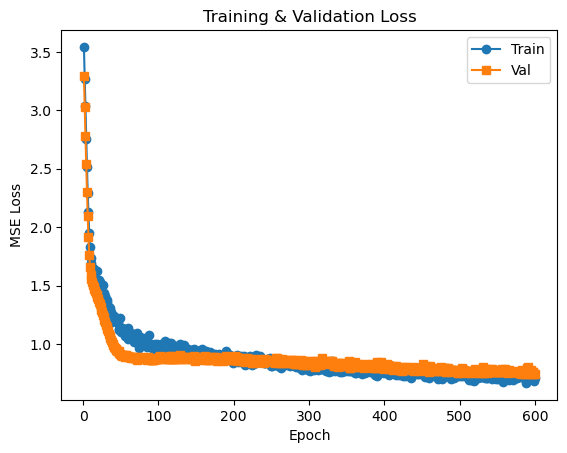

Test Loss: 0.7221
Test Loss: 0.6567
Test Loss: 0.6561
Test Loss: 0.6407
Test Loss: 0.6346
Test Loss: 0.6348


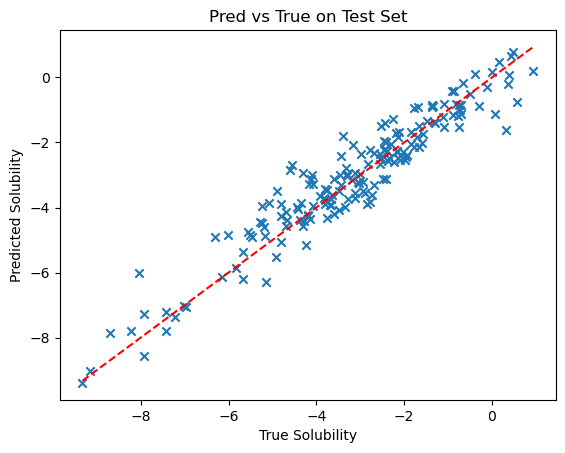

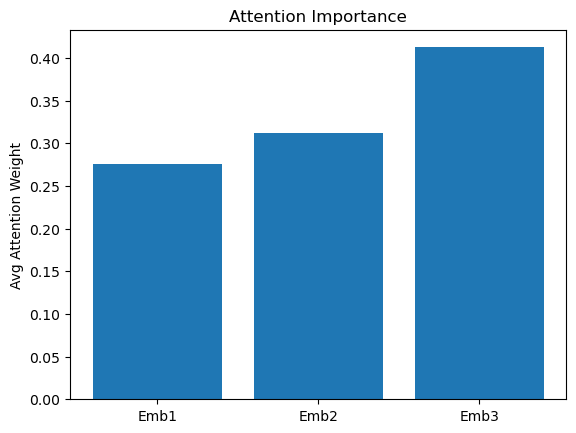

In [ ]:
plt.figure()
plt.plot(range(1, epochs+1), train_losses, marker='o', label='Train')
plt.plot(range(1, epochs+1), val_losses,   marker='s', label='Val')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

model.eval()
y_true, y_pred, attn_list = [], [], []
with torch.no_grad():
    for xb, yb, global_features in test_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        global_features = global_features.to(device, non_blocking=True)
        preds, weights = model(xb, global_features)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        attn_list.append(weights.cpu().numpy())
        test_loss = criterion(torch.tensor(y_pred, device=device), torch.tensor(y_true, device=device))**0.5
        print(f"Test Loss: {test_loss.item():.4f}")
attn = np.vstack(attn_list)

plt.figure()
plt.scatter(y_true, y_pred, marker='x')
mn, mx = min(y_true), max(y_true)
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel('True Solubility')
plt.ylabel('Predicted Solubility')
plt.title('Pred vs True on Test Set')
plt.show()

avg_weights = attn.mean(axis=0)
plt.figure()
plt.bar(['Emb1','Emb2','Emb3'], avg_weights)
plt.ylabel('Avg Attention Weight')
plt.title('Attention Importance')
plt.show()

In [ ]:
class MLP(nn.Module):
    def __init__(self, emb_dim, hidden_dim=64):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        out = self.mlp(x).squeeze(-1)
        return out

In [ ]:
for xb, yb in train_loader:
    xb = torch.cat([xb[:, i, :] for i in range(xb.size(1))], dim=1)
    print(xb.shape)
    break

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emb_dim   = embeddings.shape[-1]*3
model     = MLP(emb_dim=emb_dim).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 300
train_losses, val_losses = [], []

for epoch in range(1, epochs+1):
    model.train()
    total_train = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device, non_blocking=True)
        xb = torch.cat([xb[:, i, :] for i in range(xb.size(1))], dim=1)
        yb = yb.to(device, non_blocking=True)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_train += loss.item() * xb.size(0)
    train_losses.append((total_train / len(train_ds))**0.5)

    model.eval()
    total_val = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device, non_blocking=True)
            xb = torch.cat([xb[:, i, :] for i in range(xb.size(1))], dim=1)
            yb = yb.to(device, non_blocking=True)
            preds = model(xb)
            total_val += criterion(preds, yb).item() * xb.size(0)
    val_losses.append((total_val / len(val_ds))**0.5)
    print(f"Epoch {epoch}/{epochs} — Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

In [ ]:
plt.figure()
plt.plot(range(1, epochs+1), train_losses, marker='o', label='Train')
plt.plot(range(1, epochs+1), val_losses,   marker='s', label='Val')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

model.eval()
y_true, y_pred, attn_list = [], [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        xb = torch.cat([xb[:, i, :] for i in range(xb.size(1))], dim=1)
        yb = yb.to(device, non_blocking=True)
        preds = model(xb)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        attn_list.append(weights.cpu().numpy())
        test_loss = criterion(torch.tensor(y_pred, device=device), torch.tensor(y_true, device=device))**0.5
        print(f"Test Loss: {test_loss.item():.4f}")
attn = np.vstack(attn_list) 

plt.figure()
plt.scatter(y_true, y_pred, marker='x')
mn, mx = min(y_true), max(y_true)
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel('True Solubility')
plt.ylabel('Predicted Solubility')
plt.title('Pred vs True on Test Set')
plt.show()

In [ ]:
class WeightedFusion(nn.Module):
    def __init__(self, num_inputs=3, emb_dim=512, dropout=0.1, layer_norm_out=True):
        super().__init__()
        self.emb_dim = emb_dim
        self.num_inputs = num_inputs
        self.linear = nn.Sequential(
            nn.Linear(emb_dim, emb_dim), nn.ReLU(),
            nn.Linear(emb_dim, emb_dim)
        )
        self.weight_logits = nn.Parameter(torch.zeros(num_inputs))  # initialized to uniform weights
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(emb_dim) if layer_norm_out else None
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, embs):  # embs: [B, N, D]
        B, N, D = embs.size()
        x = self.linear(embs)  # shape [B, N, D]
        norm_weights = torch.softmax(self.weight_logits, dim=0)  # shape [N]
        fused = torch.einsum('bnd,n->bd', x, norm_weights)  # [B, D]
        fused = self.dropout(fused)
        if self.layer_norm is not None:
            fused = self.layer_norm(fused)
        out = self.mlp(fused).squeeze(-1)
        return out, norm_weights

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emb_dim   = embeddings.shape[-1]
model     = WeightedFusion(emb_dim=emb_dim).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-5)

epochs = 100
train_losses, val_losses = [], []

for epoch in range(1, epochs+1):
    model.train()
    total_train = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        optimizer.zero_grad()
        preds, _ = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_train += loss.item() * xb.size(0)
    train_losses.append((total_train / len(train_ds))**0.5)

    model.eval()
    total_val = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            preds, _ = model(xb)
            total_val += criterion(preds, yb).item() * xb.size(0)
    val_losses.append((total_val / len(val_ds))**0.5)
    print(f"Epoch {epoch}/{epochs} — Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

In [ ]:
plt.figure()
plt.plot(range(1, epochs+1), train_losses, marker='o', label='Train')
plt.plot(range(1, epochs+1), val_losses,   marker='s', label='Val')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

model.eval()
y_true, y_pred, attn_list = [], [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        preds, weights = model(xb)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        attn_list.append(weights.cpu().numpy())
        test_loss = criterion(torch.tensor(y_pred, device=device), torch.tensor(y_true, device=device))**0.5
        print(f"Test Loss: {test_loss.item():.4f}")
attn = np.vstack(attn_list)

plt.figure()
plt.scatter(y_true, y_pred, marker='x')
mn, mx = min(y_true), max(y_true)
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel('True Solubility')
plt.ylabel('Predicted Solubility')
plt.title('Pred vs True on Test Set')
plt.show()

avg_weights = attn.mean(axis=0)
plt.figure()
plt.bar(['Emb1','Emb2','Emb3'], avg_weights)
plt.ylabel('Avg Attention Weight')
plt.title('Attention Importance')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np

def load_data_for_visualization(name, batch_size=32, val_split=0.1, test_split=0.2, seed=42):
    df = pd.read_csv(f'data/{name}.csv')
    smiles_list = df['smiles'].tolist()
    labels = df[name].tolist()

    data_list = smiles2graph(smiles_list, labels)

    train_val, test_data = train_test_split(data_list, test_size=test_split, random_state=seed)
    train_data, val_data = train_test_split(
        train_val, test_size=val_split/(1 - test_split), random_state=seed
    )

    train_loader = GeoDataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = GeoDataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = GeoDataLoader(test_data, batch_size=batch_size, shuffle=False)

    test_smiles_list = [data.smiles for data in test_data]

    return train_loader, val_loader, test_loader, test_smiles_list


def plot_best_and_worst(preds, labs, smiles_list, dataset_name, fusion_method, out_dir='results'):
    # Ensure smiles_list length matches the preds and labs lengths
    assert len(preds) == len(labs) == len(smiles_list), "Preds, labs, and smiles_list must have the same length."
    
    # Calculate the differences
    diffs = np.abs(preds - labs)
    
    # Sort based on the differences (for both best and worst)
    best_indices = np.argsort(diffs)[:15]  
    worst_indices = np.argsort(diffs)[-15:]  
    
    # Prepare data for plotting
    best_preds, best_labs = preds[best_indices], labs[best_indices]
    worst_preds, worst_labs = preds[worst_indices], labs[worst_indices]
    best_smiles, worst_smiles = [smiles_list[i] for i in best_indices], [smiles_list[i] for i in worst_indices]

    # Create a PDF to save the plots
    pdf_path = f'{out_dir}/{dataset_name}_{fusion_method}_best_worst_2.pdf'
    with PdfPages(pdf_path) as pdf:
        # Plot for best 15 molecules
        fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # 3x5 grid for best 15 molecules
        axes = axes.flatten()
        for i, (smiles, pred, lab) in enumerate(zip(best_smiles, best_preds, best_labs)):
            mol = Chem.MolFromSmiles(smiles)
            img = Draw.MolToImage(mol, size=(200, 200))  # Resize the image to ensure consistent display
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f"Pred: {pred:.2f}\nTrue: {lab:.2f}", fontsize=10)
        
        plt.suptitle(f'{dataset_name} - {fusion_method} - Best 15 Molecules', fontsize=16)
        pdf.savefig()  # Save the plot to the PDF
        plt.close()

        # Plot for worst 15 molecules
        fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # 3x5 grid for worst 15 molecules
        axes = axes.flatten()
        for i, (smiles, pred, lab) in enumerate(zip(worst_smiles, worst_preds, worst_labs)):
            mol = Chem.MolFromSmiles(smiles)
            img = Draw.MolToImage(mol, size=(200, 200))  # Resize the image to ensure consistent display
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f"Pred: {pred:.2f}\nTrue: {lab:.2f}", fontsize=10)
        
        plt.suptitle(f'{dataset_name} - {fusion_method} - Worst 15 Molecules', fontsize=16)
        pdf.savefig()  # Save the plot to the PDF
        plt.close()
        
    print(f"Best and worst plots saved to {pdf_path}")


def run_and_plot(fusion_method, dataset, best_params, out_dir):
    # Load data
    tr, vl, te, tsl = load_data_for_visualization(
    dataset, batch_size=best_params['batch_size'], 
    val_split=best_params['val_split'], test_split=best_params['test_split'], seed=42)

    sample = tr.dataset[0]
    
    # Get model
    model = get_finetune_model(fusion_method, sample, dropout=best_params['dropout'])
    
    # Train the model
    tr_losses, val_rmses = train_and_validate(model, tr, vl, epochs=best_params['epochs'])
    
    # Test the model
    rmse_test, preds, labs = test_model(model, te)
    
    # Plot and save best and worst molecules
    plot_best_and_worst(preds, labs, tsl, fusion_method, out_dir)
best_params = {
    'batch_size': 16,
    'val_split': 0.1,
    'test_split': 0.2,
    'epochs': 100,
    'dropout': 0.3,
    'seed': 42,
    'weight_decay': 0,
}

out_dir = 'results'
run_and_plot('attention', 'freesolv', best_params, out_dir)
